<a href="https://colab.research.google.com/github/mafaldasalomao/pavic_treinamento_ml/blob/main/PAVIC_ML_24_rnn_multiplas_saidas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão do preço de ações com redes neurais recorrentes - múltiplas saídas

## Etapa 1: Importação das bibliotecas

In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn.metrics import mean_absolute_error
torch.__version__

'2.0.1+cu118'

In [27]:
torch.manual_seed(123)

## Etapa 2: Base de dados

In [28]:
base = pd.read_csv('petr4_treinamento.csv')
base = base.dropna()
base_train = base.iloc[:, 1:3].values

In [29]:
base.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [30]:
base_train

array([[19.99    , 20.209999],
       [19.809999, 20.4     ],
       [20.33    , 20.620001],
       ...,
       [15.99    , 16.139999],
       [16.1     , 16.129999],
       [16.1     , 16.1     ]])

In [31]:
normalizador = MinMaxScaler(feature_range = (0, 1))
base_train_norm = normalizador.fit_transform(base_train)

In [32]:
X = []
y = []
for i in range(90, 1242):
    X.append(base_train_norm[i-90:i, 0])
    y.append(base_train_norm[i, 0:2]) # `y` terá duas colunas
X, y = np.array(X), np.array(y)

In [33]:
X[0]

array([0.76501938, 0.7562984 , 0.78149225, 0.78875969, 0.77083338,
       0.74806197, 0.75436047, 0.75823643, 0.76598837, 0.76598837,
       0.76017437, 0.75872098, 0.75581391, 0.74467054, 0.7374031 ,
       0.7374031 , 0.73498067, 0.75242248, 0.73401163, 0.71656977,
       0.68120155, 0.67538755, 0.67635659, 0.63372098, 0.66521318,
       0.65649225, 0.64680228, 0.66618222, 0.65843028, 0.64970935,
       0.65116274, 0.66424419, 0.67344961, 0.64292631, 0.64486434,
       0.62257747, 0.60949617, 0.60998067, 0.60852713, 0.59593023,
       0.61143411, 0.60222863, 0.64922481, 0.68362398, 0.70687989,
       0.68265509, 0.70978682, 0.70784879, 0.71608527, 0.73643411,
       0.7122093 , 0.7122093 , 0.7194767 , 0.70348832, 0.69525189,
       0.70397287, 0.70397287, 0.69767442, 0.68168605, 0.68168605,
       0.65310078, 0.66618222, 0.64825581, 0.66182175, 0.64341085,
       0.67877902, 0.69137592, 0.66569772, 0.65406982, 0.64292631,
       0.64147292, 0.63565891, 0.67587209, 0.68653106, 0.70300

In [34]:
y[0]

array([0.76114341, 0.76490543])

In [35]:
X = torch.tensor(X, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.float32)

In [36]:
dataset = torch.utils.data.TensorDataset(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)

## Etapa 3: Construção da rede neural recorrente

In [37]:
class regressor_LSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm1 = nn.LSTM(input_size = 1, hidden_size = 100, batch_first = True)
        self.lstm2 = nn.LSTM(100, 50, batch_first = True)
        self.lstm3 = nn.LSTM(50, 50, dropout = 0.3, num_layers = 2, batch_first = True)
        self.dropout = nn.Dropout(p = 0.3)
        self.linear = nn.Linear(in_features = 50, out_features = 2)

    def forward(self, X):
        X = X.unsqueeze(2)
        X, _ = self.lstm1(X)
        X = self.dropout(X)
        X, _ = self.lstm2(X)
        X = self.dropout(X)
        X, _ = self.lstm3(X)

        X = X[:, -1, :]
        X = self.dropout(X)
        X = self.linear(X)

        return X

In [38]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [39]:
regressor = regressor_LSTM()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(regressor.parameters(), lr = 1e-3, alpha = 0.9)
regressor.to(device)

regressor_LSTM(
  (lstm1): LSTM(1, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (lstm3): LSTM(50, 50, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

## Etapa 4: Treinamento do modelo

In [40]:
for epoch in range(100):
    running_loss = 0.
    running_mae = 0.

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = regressor(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        mae = mean_absolute_error(labels.detach().cpu().numpy().flatten(),
                                  outputs.detach().cpu().numpy().flatten())
        running_mae += mae

        # Imprimindo os dados referentes a esse loop
        print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: custo {:03.5f} - MAE {:03.5f}'.format(epoch + 1, i + 1, len(loader), loss, mae), end = '\r')

    # Imprimindo os dados referentes a essa época
    running_loss /= len(loader)
    running_mae /= len(loader)
    print('ÉPOCA {:3d} FINALIZADA: custo {:03.6f} - MAE {:03.6f}     '.format(epoch + 1, running_loss, running_mae))


ÉPOCA   1 FINALIZADA: custo 0.061920 - MAE 0.196798     
ÉPOCA   2 FINALIZADA: custo 0.029633 - MAE 0.137026     
ÉPOCA   3 FINALIZADA: custo 0.019976 - MAE 0.110203     
ÉPOCA   4 FINALIZADA: custo 0.015484 - MAE 0.098810     
ÉPOCA   5 FINALIZADA: custo 0.014008 - MAE 0.091936     
ÉPOCA   6 FINALIZADA: custo 0.012193 - MAE 0.085557     
ÉPOCA   7 FINALIZADA: custo 0.010865 - MAE 0.080261     
ÉPOCA   8 FINALIZADA: custo 0.009532 - MAE 0.074878     
ÉPOCA   9 FINALIZADA: custo 0.009055 - MAE 0.074551     
ÉPOCA  10 FINALIZADA: custo 0.008331 - MAE 0.070445     
ÉPOCA  11 FINALIZADA: custo 0.007640 - MAE 0.066143     
ÉPOCA  12 FINALIZADA: custo 0.007158 - MAE 0.065113     
ÉPOCA  13 FINALIZADA: custo 0.006979 - MAE 0.065250     
ÉPOCA  14 FINALIZADA: custo 0.006399 - MAE 0.061930     
ÉPOCA  15 FINALIZADA: custo 0.005900 - MAE 0.058943     
ÉPOCA  16 FINALIZADA: custo 0.005169 - MAE 0.055925     
ÉPOCA  17 FINALIZADA: custo 0.005247 - MAE 0.055790     
ÉPOCA  18 FINALIZADA: custo 0.0

## Etapa 5: Processamento da base de teste

In [41]:
base_teste = pd.read_csv('petr4_teste.csv')
base_completa = pd.concat((base['Open'], base_teste['Open']), axis = 0)
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = entradas.reshape(-1, 1)

In [42]:
normalizador = MinMaxScaler().fit(base_train[:, 0:1])
entradas = normalizador.transform(entradas)

In [43]:
X_teste = []
for i in range(90, 112):
    X_teste.append(entradas[i-90:i, 0])
X_teste = np.array(X_teste)

In [44]:
X_teste = torch.tensor(X_teste, device = device, dtype = torch.float32)

## Etapa 6: Previsões

In [45]:
regressor.eval()
previsoes = regressor(X_teste)
previsoes = previsoes.detach().cpu().numpy()
previsoes = normalizador.inverse_transform(previsoes)

In [46]:
previsoes

array([[15.48412 , 15.660139],
       [15.533309, 15.709833],
       [15.762564, 15.940838],
       [16.035368, 16.216028],
       [16.024233, 16.20546 ],
       [16.012112, 16.19348 ],
       [16.224087, 16.407093],
       [16.212702, 16.396072],
       [16.149727, 16.332773],
       [16.247982, 16.431705],
       [16.491297, 16.676996],
       [16.565365, 16.752132],
       [16.967175, 17.157324],
       [17.381252, 17.575628],
       [17.403976, 17.599768],
       [17.32413 , 17.519817],
       [17.409258, 17.60575 ],
       [17.460354, 17.657541],
       [18.146446, 18.349522],
       [18.496086, 18.70388 ],
       [18.529943, 18.739466],
       [18.574274, 18.784891]], dtype=float32)

In [47]:
previsoes.mean(axis = 0)

array([16.837992, 17.028006], dtype=float32)

In [48]:
base_teste['Open'].mean()

17.87454563636364

In [49]:
base_teste['High'].mean()

18.148181636363635

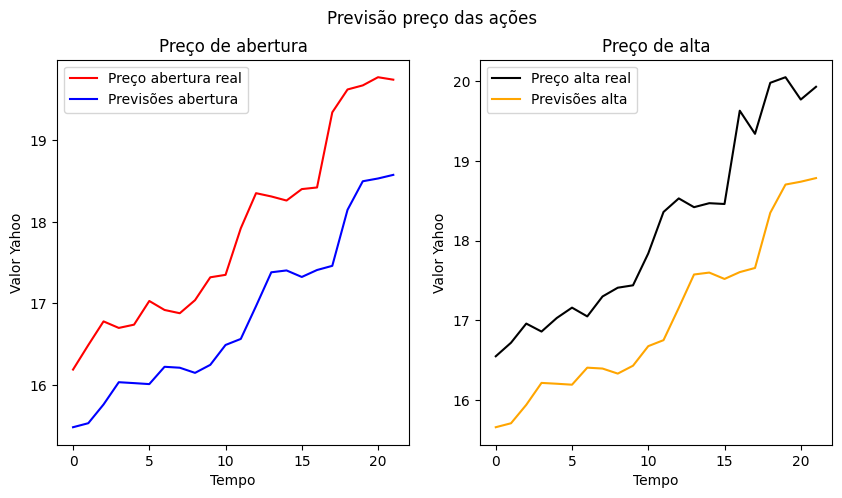

In [50]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Previsão preço das ações')

ax[0].plot(base_teste['Open'], color = 'red', label = 'Preço abertura real')
ax[0].plot(previsoes[:, 0], color = 'blue', label = 'Previsões abertura')
ax[0].set_title('Preço de abertura')
ax[0].set_xlabel('Tempo')
ax[0].set_ylabel('Valor Yahoo')
ax[0].legend()

ax[1].plot(base_teste['High'], color = 'black', label = 'Preço alta real')
ax[1].plot(previsoes[:, 1], color = 'orange', label = 'Previsões alta')
ax[1].set_title('Preço de alta')
ax[1].set_xlabel('Tempo')
ax[1].set_ylabel('Valor Yahoo')
ax[1].legend()